<a href="https://colab.research.google.com/github/shalabh147/Brain-Tumor-Segmentation-and-Survival-Prediction-using-Deep-Neural-Networks/blob/master/surv_pred_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import pandas as pd
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, concatenate, Flatten
from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout, ReLU, LeakyReLU, BatchNormalization

from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers, initializers, optimizers
from tensorflow.keras.optimizers import Adam, SGD

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
path_project = '/home/origin/Research/'
path_clinical = path_project + 'Data/clinical/Pre-operative_TCGA-GBM/survival_info_all.csv'
path_MRI = path_project + 'Data/MRI/Pre-operative/All/'

IDs_patients = os.listdir(path_MRI)
IDs_patients.sort()
count_patients = len(IDs_patients)
age_dict = {}
OS_dict = {}
threshold = 360 # days
seg_label = 'GlistrBoost.nii'


def standardize(image):
  standardized_image = np.zeros(image.shape)
  # iterate over the `z` dimension
  for z in range(image.shape[2]):
    # get a slice of the image at channel c and z-th dimension `z`
    image_slice = image[:, :, z]
    # subtract the mean from image_slice
    centered = image_slice - np.mean(image_slice)
    # divide by the standard deviation (only if it is different from zero)
    if np.std(centered) != 0:
        centered = centered / np.std(centered)
    # update  the slice of standardized image with the scaled centered and scaled image
    standardized_image[:, :, z] = centered
    
  return standardized_image

In [3]:
dtypes = dict.fromkeys(pd.read_csv(path_clinical, encoding='gbk', nrows=1).columns.tolist(), str)
data_clinical = pd.read_csv(path_clinical, encoding='gbk', dtype=dtypes)

# produce the dict of age and overall survival
head_IDs, head_age, head_OS = list(dtypes.keys())[0], list(dtypes.keys())[1], list(dtypes.keys())[2]
cases_IDs = list(data_clinical[head_IDs])
cases_age = list(data_clinical[head_age].apply(pd.to_numeric, errors='coerce').fillna(0))
cases_OS = list(data_clinical[head_OS].apply(pd.to_numeric, errors='coerce').fillna(0))
age_dict = dict(zip(cases_IDs, cases_age))
OS_dict = dict(zip(cases_IDs, cases_OS))

In [4]:
# set loading
input_set_all = os.listdir(path_MRI)
input_set = []
slice_loc_all = []

for IDs in input_set_all:
    if IDs in OS_dict.keys():
        input_set.append(IDs)
        
count_patients= len(input_set)
input_all = np.zeros((count_patients, 240, 240, 5))
age_all = np.zeros((count_patients, 1))
ground_truth_all = np.zeros((count_patients, 2))
cnt = 0
for image_num in range(count_patients):
    x = input_set[image_num]
    folder_path = path_MRI + x
    modalities = os.listdir(folder_path)
    modalities.sort()

    data = np.zeros((240, 240, 155, 4))
    image_data2 = np.zeros((240, 240, 155))
    w = 0
    for j in range(len(modalities)):
        image_path = folder_path + '/' + modalities[j]
        if not (image_path.find(seg_label) == -1):
            img = nib.load(image_path)
            image_data2 = img.get_fdata()
            image_data2 = np.asarray(image_data2)
            image_data2 = standardize(image_data2)
        else:
            img = nib.load(image_path)
            image_data = img.get_fdata()
            image_data = np.asarray(image_data)
            image_data = standardize(image_data)
            data[:, :, :, w] = image_data
            w = w + 1

    image_data2[image_data2 == 4] = 3
    slice_nonzero = []
    width, height, queue = image_data2.shape
    for i in range(0, queue, 10):
        image_array = image_data2[:, :, i]
        slice_nonzero.append(np.count_nonzero(image_array))
    slice_nonzero_array = np.array(slice_nonzero)
    slice_loc_all.append(slice_nonzero_array.argmax() * 10)

    input_all[cnt, :, :, :4] = data[:, :, slice_loc_all[image_num], :]
    input_all[cnt, :, :, 4] = image_data2[:, :, slice_loc_all[image_num]]
    age_all[cnt, 0] = float(age_dict[x])
    OS_all = int(OS_dict[x])

    if int(OS_all) < threshold:
        ground_truth_all[cnt, 0] = 1
    else:
        ground_truth_all[cnt, 1] = 1
    cnt += 1
    
print('input set: ', len(input_all))

input set:  121


In [ ]:
# number_training = 104
# number_val = 17

# validation_index = random.sample(range(0, len(input_all)), number_val)
# validation_index.sort()
# print(validation_index)

In [ ]:
# input_training = np.zeros((number_training, 240, 240, 5))
# age_training = np.zeros((number_training, 1))
# ground_truth_training = np.zeros((number_training, 2))

# input_val = np.zeros((number_val, 240, 240, 5))
# age_val = np.zeros((number_val, 1))
# ground_truth_val = np.zeros((number_val, 2))

# index_training = 0
# index_val = 0

# for i in range(count_patients):
#     if i in validation_index:
#         input_val[index_val, :, :, :] = input_all[i, :, :, :]
#         age_val[index_val, 0] = age_all[i, 0]
#         ground_truth_val[index_val, :] = ground_truth_all[i, :]
#     else:
#         input_training[index_training, :, :, :] = input_all[i, :, :, :]
#         age_training[index_training, 0] = age_all[i, 0]
#         ground_truth_training[index_training, :] = ground_truth_all[i, :]
        
# print(len(input_training), len(age_training), len(ground_truth_training))
# print(len(input_val), len(age_val), len(ground_truth_val))

In [ ]:
cnt = 0
for patients_num in range(len(IDs_patients)):
  image1 = IDs_patients[patients_num]
  if image1 in OS_dict:
    cnt += 1
print('the number of patients who have age and OS information: ', cnt)

print('the slices of 3D scans are: ', slice_loc_all)

In [5]:
def SurvPredNet(input_img, age_m):
    
    model = Sequential()
    
#     a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(input_img)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Conv2D(64,kernel_size = (3,3) , padding='same')(a1)
#     a1 = Activation('relu')(a1)
#     a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(input_img)
    a1 = Activation('relu')(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = Activation('relu')(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = Activation('relu')(a1)
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Flatten()(a1)
    a1 = concatenate([a1,age_m])
    
    a1 = Dense(32,activation = 'relu')(a1)
    a1 = Dense(16,activation = 'relu')(a1)
    outputs = Dense(2,activation = 'softmax')(a1)
    
    model = Model(inputs = [input_img, age_m] , outputs = outputs)
    return model

# saveModel = path_project + 'Thesis/Experiments_Record/my_code/20220815/1/Model/'
# checkpoint = callbacks.ModelCheckpoint(saveModel+'weights.{epoch:02d}.h5', monitor='val_accuracy', verbose=0,
#                                 save_best_only=True,
#                                 save_weights_only=False, mode='max')

In [70]:
lr = 1e-5
decay_rate = 2e-7
input_img = Input((240,240,5))
age_m = Input(1)
model = SurvPredNet(input_img, age_m)

# accu_metric = 'categorical_accuracy'
accu_metric = 'accuracy'
sgd = optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=accu_metric)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=accu_metric)
# model.compile(loss='categorical_crossentropy',
#              optimizer=tf.keras.optimizers.SGD(learning_rate =0.0001),
#              metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 240, 240, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 240, 240, 32  1472        ['input_57[0][0]']               
                                )                                                                 
                                                                                                  
 activation_84 (Activation)     (None, 240, 240, 32  0           ['conv2d_84[0][0]']              
                                )                                                          

In [71]:
epoch=80
bz=16

history = model.fit(x=[input_all, age_all], y=ground_truth_all, epochs=epoch, batch_size=bz, 
                   validation_split=0.15)

# history = model.fit(x=[input_training, age_training], y=ground_truth_training, epochs=epoch, batch_size=bz, 
#                    validation_data=[[input_val, age_val], ground_truth_val])

# history = model.fit(x=[input_training, age_training], y=ground_truth_training, epochs=epoch, batch_size=bz, 
#                     validation_data=[[input_val, age_val], ground_truth_val], 
#                     callbacks=checkpoint)

Epoch 1/80
7/7 [==============================] - 1s 59ms/step - loss: 0.7293 - accuracy: 0.4608 - val_loss: 0.6838 - val_accuracy: 0.5263
Epoch 2/80
7/7 [==============================] - 0s 45ms/step - loss: 0.7071 - accuracy: 0.4804 - val_loss: 0.6851 - val_accuracy: 0.5789
Epoch 3/80
7/7 [==============================] - 0s 44ms/step - loss: 0.6774 - accuracy: 0.5490 - val_loss: 0.7047 - val_accuracy: 0.4737
Epoch 4/80
7/7 [==============================] - 0s 48ms/step - loss: 0.6543 - accuracy: 0.6471 - val_loss: 0.7136 - val_accuracy: 0.5263
Epoch 5/80
7/7 [==============================] - 0s 45ms/step - loss: 0.6296 - accuracy: 0.6373 - val_loss: 0.6908 - val_accuracy: 0.6316
Epoch 6/80
7/7 [==============================] - 0s 46ms/step - loss: 0.6068 - accuracy: 0.7157 - val_loss: 0.6622 - val_accuracy: 0.5789
Epoch 7/80
7/7 [==============================] - 0s 46ms/step - loss: 0.5790 - accuracy: 0.7843 - val_loss: 0.6878 - val_accuracy: 0.4737
Epoch 8/80
7/7 [===========

In [72]:
######################################## change the save path here ########################################
savepath = path_project + 'Thesis/Experiments_Record/my_code/all_modalities/shuffle/6/'
######################################## change the save path here ########################################

with open(savepath + 'log_history.txt', 'wb') as file_txt:
    pickle.dump(history.history, file_txt)
    
model.save(savepath + 'LW_CNN.h5')

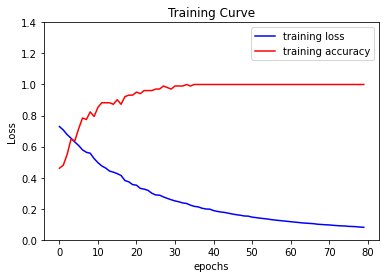

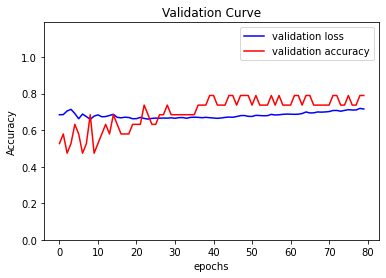

In [73]:
plt.rcParams["axes.grid"] = False
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history[accu_metric], color='red', label='training accuracy')
plt.ylim(0, max(max(history.history['loss'])+0.4, max(history.history[accu_metric])+0.4))
plt.legend()
plt.title('Training Curve')
plt.ylabel('Loss')
plt.xlabel('epochs')
s = savepath + 'epochwise_training.pdf'
plt.savefig(s)
plt.show()
plt.close()

plt.rcParams["axes.grid"] = False
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.plot(history.history['val_' + accu_metric], color='red', label='validation accuracy')
plt.ylim(0,max(max(history.history['val_loss'])+0.4, max(history.history['val_' + accu_metric])+0.4))
plt.legend(bbox_to_anchor=(1,1))
plt.title('Validation Curve')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
s = savepath + 'epochwise_validation.pdf'
plt.savefig(s)
plt.show()
plt.close()

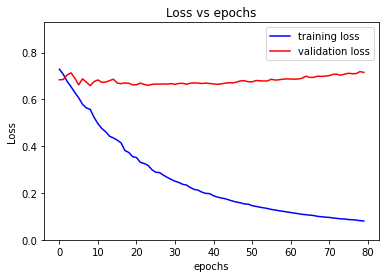

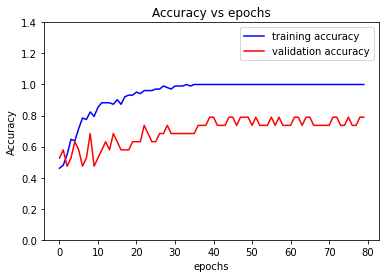

In [74]:
plt.rcParams["axes.grid"] = False
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history['val_loss'], color='red', label='validation loss')
plt.ylim(0, max(max(history.history['loss'])+0.2, max(history.history['val_loss'])+0.2))
plt.legend()
plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('epochs')
s = savepath + 'epochwise_loss.pdf'
plt.savefig(s)
plt.show()
plt.close()

plt.rcParams["axes.grid"] = False
plt.plot(history.history[accu_metric], color='blue', label='training accuracy')
plt.plot(history.history['val_' + accu_metric], color='red', label='validation accuracy')
plt.ylim(0,max(max(history.history[accu_metric])+0.4, max(history.history['val_' + accu_metric])+0.4))
plt.legend(bbox_to_anchor=(1,1))
plt.title('Accuracy vs epochs')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
s = savepath + 'epochwise_accuracy.pdf'
plt.savefig(s)
plt.show()
plt.close()

In [ ]:
# confusion matrix on validation set
y_pred = model.predict(x=[input_all, age_all])
y_true = ground_truth_all
labels = ['Short', 'Long']

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

print(C2)
sns.heatmap(C2,annot=True,ax=ax)
xlocations = np.array(range(len(labels)))+0.5
plt.xticks(xlocations, labels)
plt.yticks(xlocations, labels)
ax.set_title('confusion matrix')
ax.set_xlabel('Predict')
ax.set_ylabel('True')

print('accuracy on validation set: ', (C2[0][0]+C2[1][1])/(C2[0][0]+C2[1][1]+C2[0][1]+C2[1][0]))

plt.savefig(savepath + 'confusion_matrix_all.pdf')

# pd.crosstab(y_true.argmax(axis=1), y_pred.argmax(axis=1), rownames=['label'], colnames=['predict'])

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score

# # prediction on training set
# y_predict = model.predict([input_training, age], verbose=1)
# # y_predict = (y_predict > 0.007).astype(int)
# y_predict = (y_predict > 0.01).astype(int)
# y_true = np.reshape(ground_truth, [-1])
# y_pred = np.reshape(y_predict, [-1])
y_pred = model.predict([input_training, age_training], verbose=1)
y_pred = y_pred.argmax(axis=1)
y_true = ground_truth_training
y_true = y_true.argmax(axis=1)

# evalution index
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='binary')
f1score = f1_score(y_true, y_pred, average='binary')
# Micro F1: 将n分类的评价拆成n个二分类的评价，将n个二分类评价的TP、FP、RN对应相加，计算评价准确率和召回率，由这2个准确率和召回率计算的F1 score即为Micro F1。
# Macro F1: 将n分类的评价拆成n个二分类的评价，计算每个二分类的F1 score，n个F1 score的平均值即为Macro F1。
# 一般来讲，Macro F1、Micro F1高的分类效果好。Macro F1受样本数量少的类别影响大。
micro_f1 = f1_score(y_true, y_pred,average='micro')
macro_f1 = f1_score(y_true, y_pred,average='macro')

print('accuracy:',accuracy)
print('precision:',precision)
print('recall:',recall)
print('f1score:',f1score)
print('Macro-F1: {}'.format(macro_f1))
print('Micro-F1: {}'.format(micro_f1))

# prediction on validation set
print('\n\n')
# y_predict_val = model.predict([input_to_val, age_val], verbose=1)
# y_predict_val = (y_predict_val > 0.01).astype(int)
# y_true_val = np.reshape(ground_truth_val, [-1])
# y_pred_val = np.reshape(y_predict_val, [-1])
y_pred_val = model.predict([input_val, age_val], verbose=1)
y_pred_val = y_pred_val.argmax(axis=1)
y_true_val = ground_truth_val
y_true_val = y_true_val.argmax(axis=1)

# evalution index
accuracy_val = accuracy_score(y_true_val, y_pred_val)
precision_val = precision_score(y_true_val, y_pred_val)
recall_val = recall_score(y_true_val, y_pred_val, average='binary')
f1score_val = f1_score(y_true_val, y_pred_val, average='binary')
micro_f1_val = f1_score(y_true_val, y_pred_val,average='micro')
macro_f1_val = f1_score(y_true_val, y_pred_val,average='macro')

print('accuracy_val:',accuracy_val)
print('precision_val:',precision_val)
print('recall_val:',recall_val)
print('f1score_val:',f1score_val)
print('Macro-F1_val: {}'.format(macro_f1_val))
print('Micro-F1_val: {}'.format(micro_f1_val))

In [75]:
############################### save the hyperparameters and metrics ###############################

with open(savepath + 'log.txt','w',encoding='utf-8') as f:
    f.write('######################################\n')
    f.write('optimizer: ' + 'sgd' + '\n')
    f.write('learning rate: ' + str(lr) + '\n')
    f.write('decay rate: ' + str(decay_rate) + '\n')
    f.write('epochs: ' + str(epoch) + '\n')
    f.write('batch size: ' + str(bz) + '\n')
    
    f.write('\n\n######################################\n')
    f.write('accuracy: ' + str(history.history['val_accuracy']))
    
    f.write('\n\n######################################\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))